In [ ]:
%load_ext tensorboard

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np

train_df = pd.read_pickle("../data/train_cens.pkl.gz")
train_df.head()

,name,parent,cens_slice,index
0,XC109605,acafly,"[[0.3086012466109237, 0.30568218743577036, 0.3...","(25, 75)"
0,XC109605,acafly,"[[0.37812375487169103, 0.3725999263434882, 0.3...","(157, 207)"
0,XC109605,acafly,"[[0.38193222855739883, 0.3810666924182529, 0.3...","(260, 310)"
0,XC109605,acafly,"[[0.3523993330368658, 0.3480284909351147, 0.34...","(324, 374)"
0,XC109605,acafly,"[[0.3179275282653602, 0.3194400852268083, 0.32...","(361, 411)"


In [4]:
import tensorflow as tf

def reshape_square(arr, k=25):
    """Domain specific. Transform 12x50 matrix into a square matrix that's 25x25."""
    x = np.zeros(k*k)
    a = arr.reshape(-1)
    x[:a.shape[0]] = a
    return x.reshape(k, k, 1)
    
X = np.stack(train_df.cens_slice.apply(reshape_square))

lb = LabelBinarizer()
lb.fit(train_df.parent)
y = lb.transform(train_df.parent)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Softmax, Flatten, Dense
from tensorflow_addons.metrics import F1Score

tf.config.list_physical_devices('GPU')
def get_compiled_model(input_shape=(25, 25, 1), output_shape=397):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy', F1Score(num_classes=output_shape)])
    return model

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [33]:
# https://github.com/tensorpack/tensorpack/blob/5845ead80e3d77c89e2f1e9d5e0691324a8354cc/examples/ResNet/cifar10-preact18-mixup.py#L101-L118

def _mixup(x_in, y_in):
    n = x_in.shape[0]
    # draw from uniform instead of beta(alpha, alpha, BATCH_SIZE)
    w = np.random.uniform(0.3, 0.7, size=n)
    x_weight = w.reshape(n, 1, 1, 1)
    index = np.random.permutation(n)

    x = x_in * x_weight + x_in[index] * (1-x_weight)
    y = y_in + y_in[index]
    
    return x, y

@tf.function(input_signature=[
    tf.TensorSpec(None, tf.float64), 
    tf.TensorSpec(None, tf.int32), 
])
def mixup(x_in, y_in):
    x, y = tf.numpy_function(_mixup, [x_in, y_in], [tf.float64, tf.int32])
    return tf.data.Dataset.from_tensor_slices((
        tf.reshape(x, [-1, 25,25,1]), 
        tf.reshape(y, [-1, 397])
    ))

def add_mixup(dataset, batch_size=1024):
    return (
        dataset
        .shuffle(batch_size)
        .window(batch_size)
        .flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(batch_size), y.batch(batch_size))))
        .map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
        .flat_map(lambda x: x)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

add_mixup(test_dataset)

<PrefetchDataset shapes: ((None, 25, 25, 1), (None, 397)), types: (tf.float64, tf.int32)>

In [29]:
model = get_compiled_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 25, 25, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 6, 128)        

In [ ]:
from pathlib import Path
import datetime
logdir = Path("../data/logs") / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

checkpoint_path = "../data/models/mixup-50-128"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [36]:
history = model.fit(add_mixup(train_dataset, 256), 
                    epochs=100, 
                    validation_data=test_dataset.batch(256), 
                    callbacks=[cp_callback, tensorboard_callback])

Epoch 1/100
1725/1725 [==============================] - 83s 48ms/step - loss: 0.0292 - accuracy: 0.0433 - f1_score: 0.0199 - val_loss: 0.0162 - val_accuracy: 0.0604 - val_f1_score: 0.0280

Epoch 00001: saving model to ../data/models\mixup-50-128
Epoch 2/100
1725/1725 [==============================] - 80s 46ms/step - loss: 0.0291 - accuracy: 0.0442 - f1_score: 0.0214 - val_loss: 0.0162 - val_accuracy: 0.0602 - val_f1_score: 0.0277

Epoch 00002: saving model to ../data/models\mixup-50-128
Epoch 3/100
1725/1725 [==============================] - 75s 43ms/step - loss: 0.0291 - accuracy: 0.0450 - f1_score: 0.0225 - val_loss: 0.0162 - val_accuracy: 0.0640 - val_f1_score: 0.0306

Epoch 00003: saving model to ../data/models\mixup-50-128
Epoch 4/100
1725/1725 [==============================] - 83s 48ms/step - loss: 0.0291 - accuracy: 0.0451 - f1_score: 0.0232 - val_loss: 0.0162 - val_accuracy: 0.0634 - val_f1_score: 0.0307

Epoch 00004: saving model to ../data/models\mixup-50-128
Epoch 5/100


KeyboardInterrupt: 

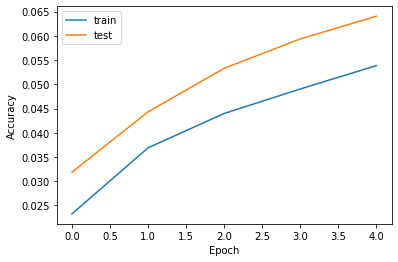

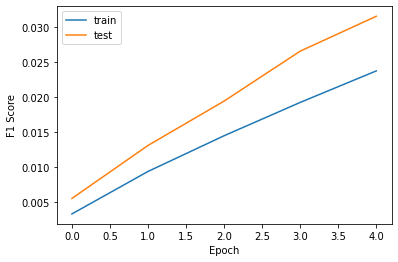

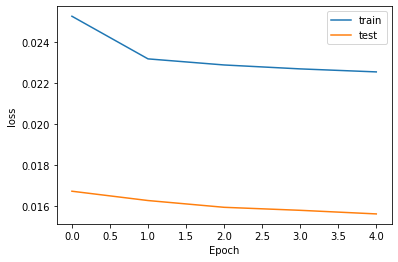

5914/5914 - 85s - loss: 0.0162 - accuracy: 0.0665 - f1_score: 0.0378


[0.01619589328765869,
 0.06648136675357819,
 array([0.00930233, 0.00938967, 0.10175879, 0.        , 0.00507614,
        0.        , 0.        , 0.        , 0.01746725, 0.08946357,
        0.        , 0.        , 0.01184834, 0.        , 0.02893891,
        0.        , 0.        , 0.        , 0.        , 0.02917772,
        0.03651116, 0.        , 0.0678426 , 0.11949306, 0.        ,
        0.        , 0.        , 0.06379894, 0.        , 0.02627737,
        0.        , 0.        , 0.04407515, 0.03404255, 0.        ,
        0.01709402, 0.04553119, 0.00747198, 0.20185031, 0.        ,
        0.06970508, 0.06408095, 0.05825243, 0.07092199, 0.        ,
        0.06530612, 0.0795756 , 0.07948244, 0.03094777, 0.11070832,
        0.00673401, 0.        , 0.        , 0.        , 0.22433461,
        0.09892086, 0.        , 0.08275862, 0.04545455, 0.06422019,
        0.01133144, 0.19708028, 0.02072539, 0.        , 0.05177993,
        0.04615384, 0.05882353, 0.        , 0.005148  , 0.        ,
    

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot([x.mean() for x in history.history['f1_score']], label='train')
plt.plot([x.mean() for x in history.history['val_f1_score']], label='test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

model.evaluate(X_test, y_test, verbose=2)